In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import *

## MeanShift
It's a non-parametric iterative mode-seeking algorithm (locating maxima of a density function), and is used for clustering, tracking, smoothing etc in computer vision. Mean shift considers feature space as a empirical probability density function. If the input is a set of points then Mean shift considers them as sampled from the underlying probability density function. If dense regions (clusters) are present in the feature space, then they correspond to the mode (local maxima) of the probability density function.

For each data point, Mean shift associates it with the nearby peak of the dataset’s probability density function. For each data point, Mean shift defines a window around it and computes the mean of the data point. Then it shifts the center of the window to the mean and repeats the algorithm till it converges. After each iteration, we can consider that the window shifts to a more denser region of the dataset.

<u>Algorithm</u>:
1. For each datapoint x ∈ X, find the neighbouring points N(x) of x.
2. For each datapoint x ∈ X, find the mean shift m(x) [Gaussian Kernel K(d) where d is distance between two datapoints]
$$m(x) = \frac{\sum_{x_{i} ∈ N(x)} K(x_{i} - x)x_{i}}{\sum_{x_{i} ∈ N(x)} K(x_{i} - x)}$$
3. For each datapoint x ∈ X, update x ← m(x)
4. Repeat 1 for 'n' iterations or till some threshold.

$$\text{Replacing   }\sum_{x_{i} ∈ N(x)} K(x_{i} - x)\text{   with }W_{i}$$
$$m(x) = \frac{\sum_{i} W_{i}x_{i}}{\sum_{i} W_{i}}$$

So, mean shift is nothing but weighted average of affected points w.r.t x

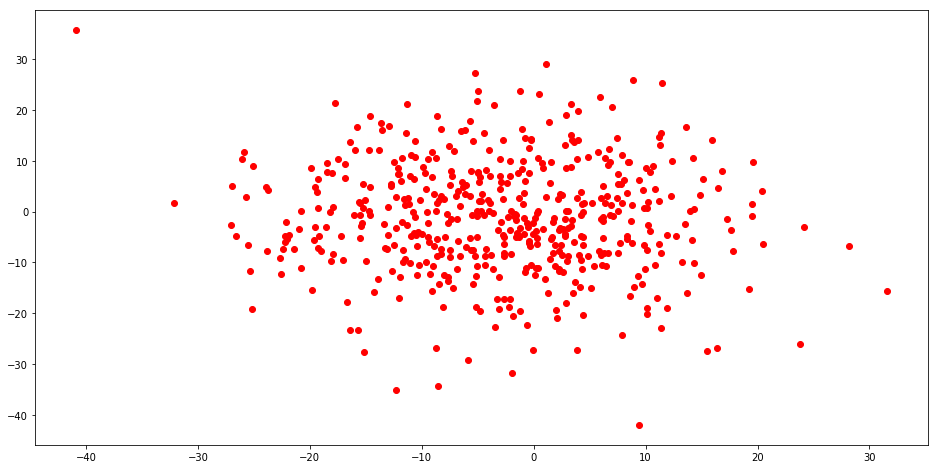

In [2]:
import matplotlib.pylab as plb
plb.rcParams['figure.figsize'] = 16, 8

# Generating 4 clusters
datapoints, x_shapes = make_blobs(n_samples=500, n_features=2, centers=6, cluster_std=10)
plt.plot(datapoints[:,0], datapoints[:, 1], 'ro')
plt.show()

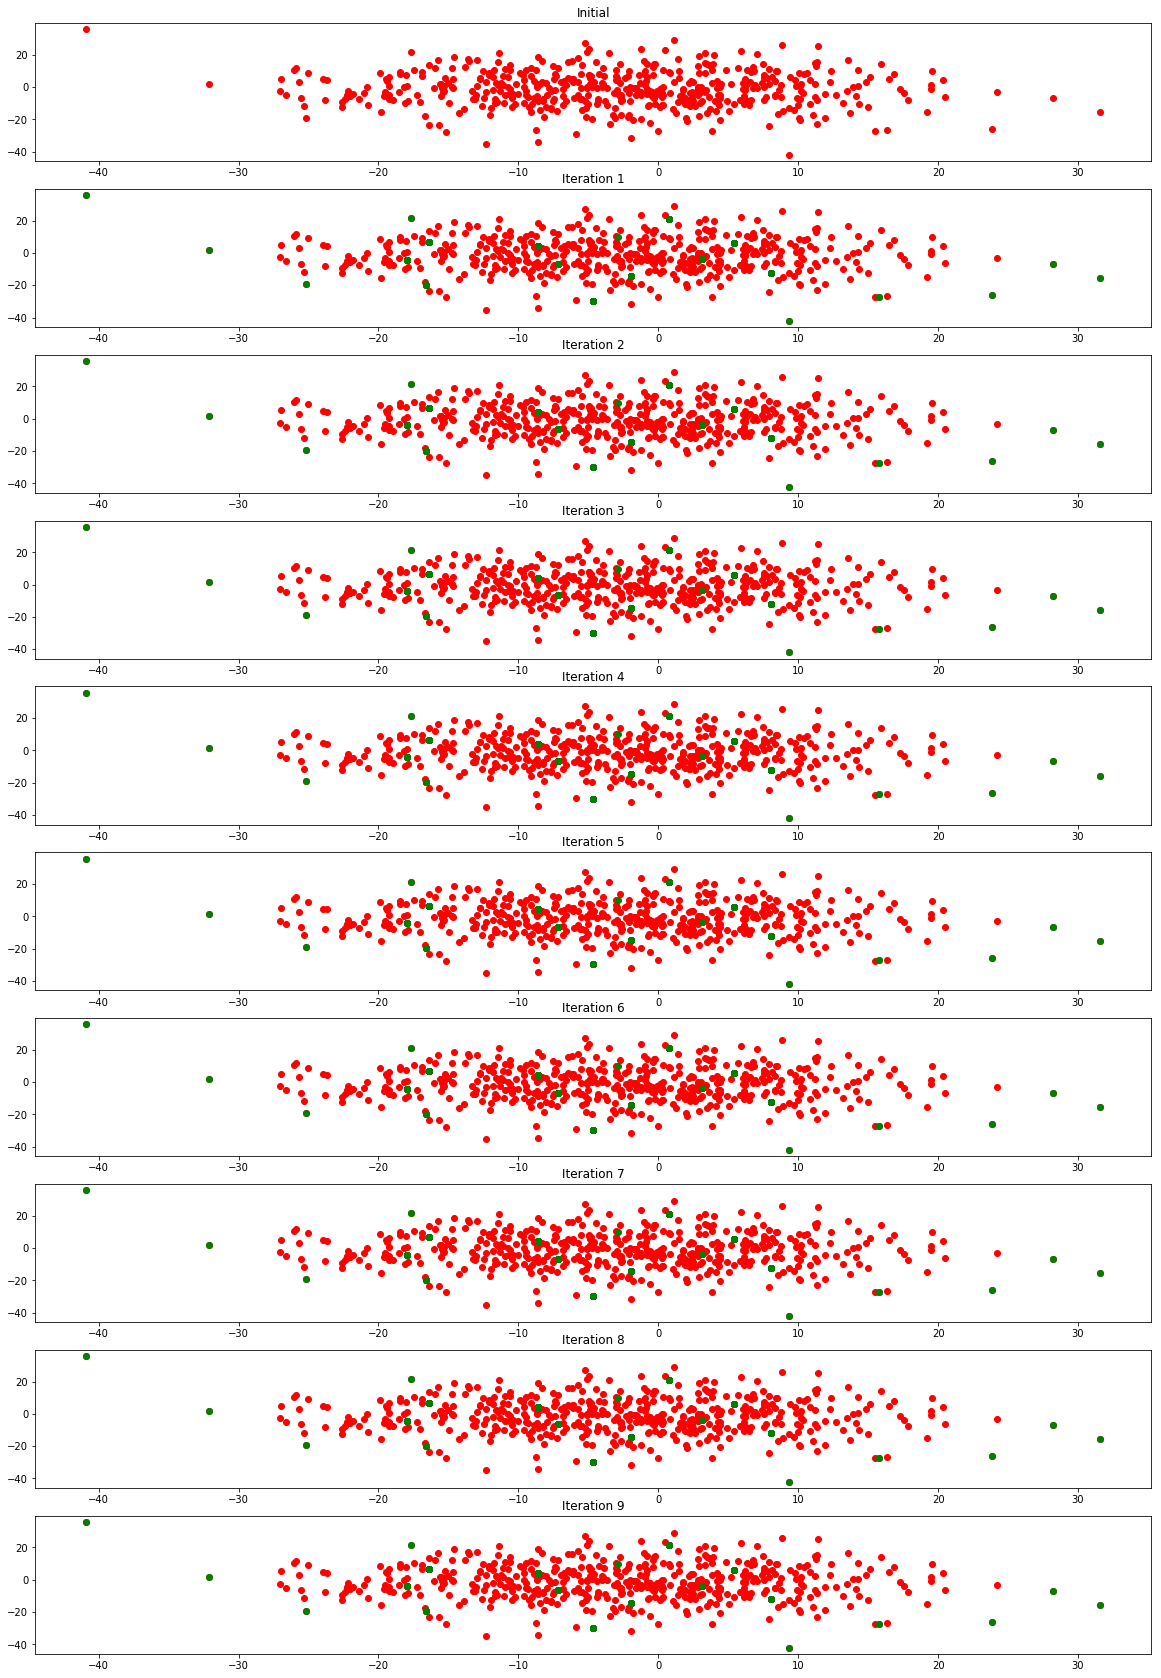

In [3]:
PI = 3.141592653589793

def neighbourhood(datapoints, centroid, threshold_dist=6):
    return [pt for pt in datapoints if np.sqrt(np.sum((pt - centroid) ** 2)) <= threshold_dist]

def gauss_kernel_weight(dist, sigma):
    return 1 / ((1 / (sigma * ((2 * PI) ** 0.5))) * np.exp(-0.5 * (dist ** 2) / (sigma ** 2)))

kernel_bandwidth = 5

data_copy = np.copy(datapoints)

changes = []
iterations = 20
temp = 0

fig = plt.figure()
fig.set_size_inches(20, 30)

for n in range(iterations):
    still = 0
    for i, pt in enumerate(data_copy):
        neighbours = neighbourhood(data_copy, pt)
        # m(x) = P / Q
        P = Q = 0
        for neighbour in neighbours:
            dist = np.sqrt(np.sum((neighbour - pt) ** 2))
            wt = gauss_kernel_weight(dist, kernel_bandwidth)
            P += (wt * neighbour)
            Q += wt
        
        m_x = P * 1.0 / Q
        
        dist = np.sqrt(np.sum((m_x - data_copy[i]) ** 2))
        if dist <= 2: still += 1
        data_copy[i] = m_x
    changes.append(data_copy)
    if still == 500: temp += 1  # stationary => convergence
    elif temp > 0: temp -= 1
    if temp > 1: break

fig.add_subplot(1 + len(changes), 1, 1)
plt.title("Initial")
plt.plot(datapoints[:, 0], datapoints[:, 1], 'ro')

for n in range(len(changes)):
    fig.add_subplot(1 + len(changes), 1, 2 + n)
    plt.title("Iteration %d" % (n + 1))
    plt.plot(datapoints[:, 0], datapoints[:, 1], 'ro')
    plt.plot(changes[n][:, 0], changes[n][:, 1], 'go')

plt.show()

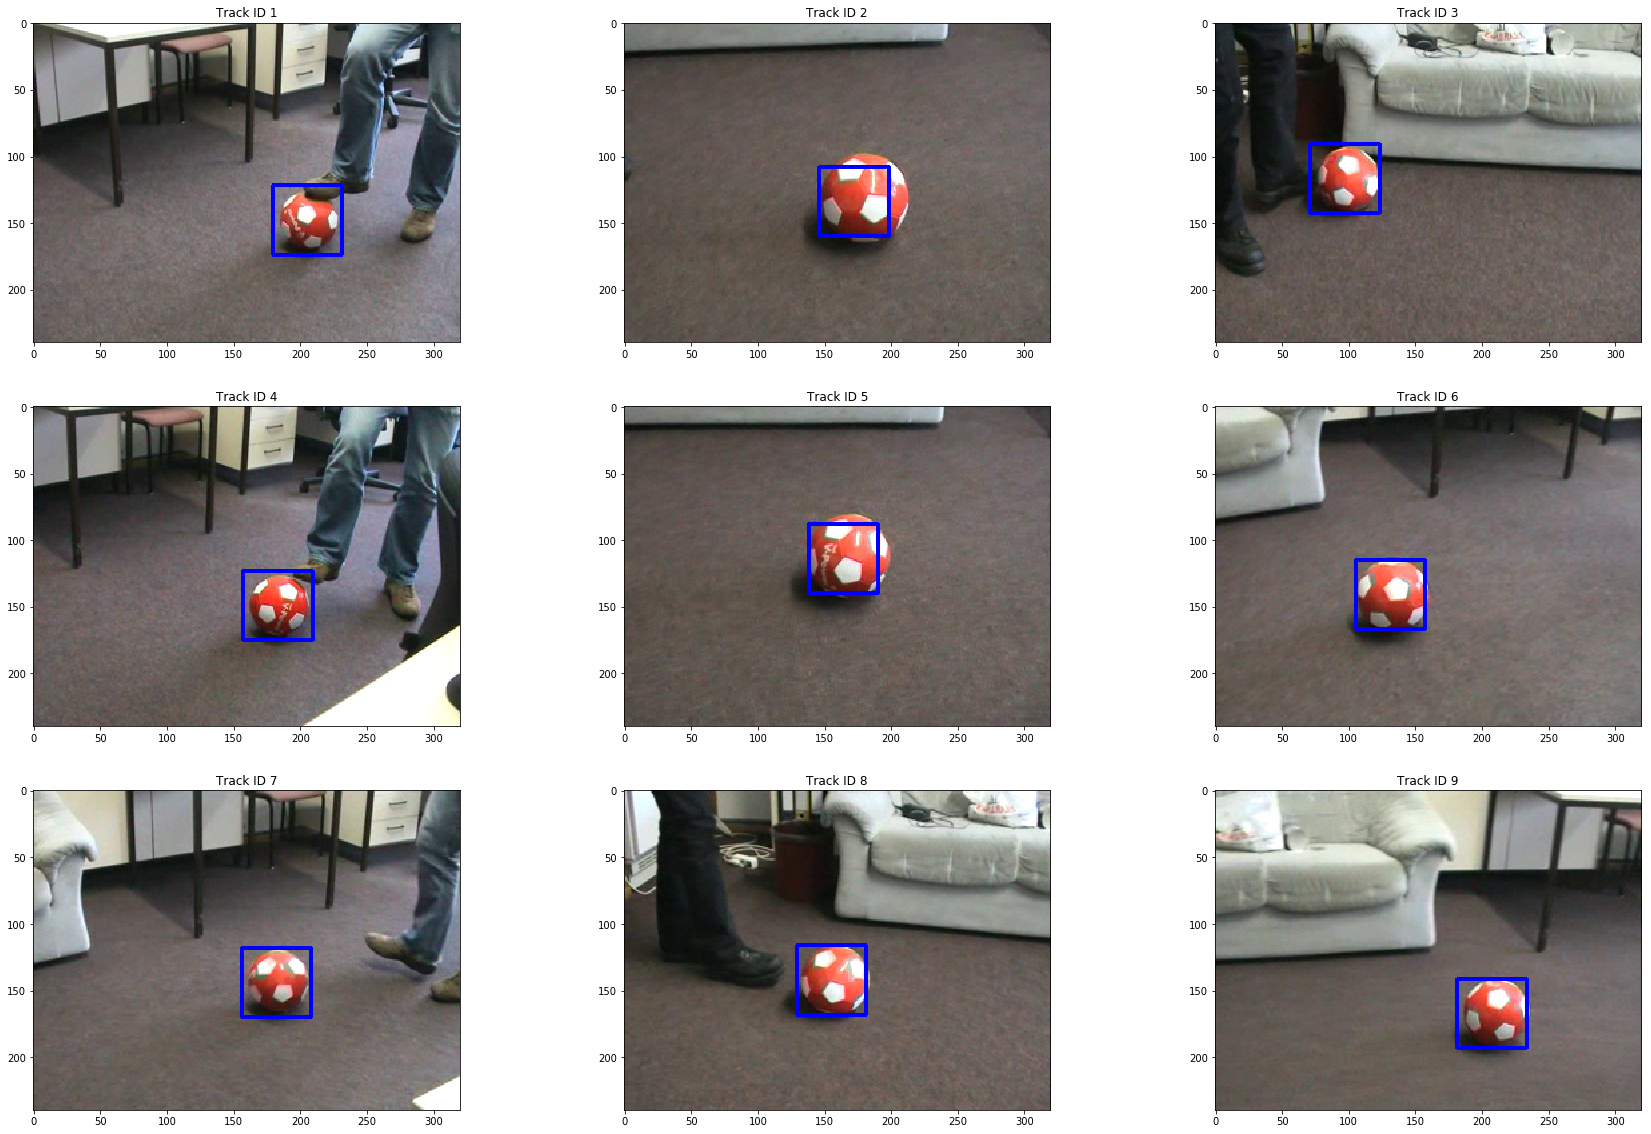

In [4]:
# Object Tracking using MeanShift
# we'll implement our own version of this, which you can find in demos
cap = cv2.VideoCapture("../resources/football.avi")

frame = cap.read()[1]
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, np.array((0, 60, 32), dtype=np.float32), np.array((180, 255, 255), dtype=np.float32))

x, y, w, h = 198, 112, 52, 52
track_window = (x, y, w, h)
hsv_roi = hsv[y : y + h, x : x + w]
mask_roi = mask[y : y + h, x : x + w]

hist = cv2.calcHist([hsv_roi], [0], mask_roi, [16], [0, 180])
cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)

hist = hist.reshape(-1)
term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)

fig = plt.figure()
fig.set_size_inches(30, 20)
batch = 0

while True:
    frame = cap.read()[1]
    if frame is None: break
    
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, np.array((0, 60, 32), dtype=np.float32), np.array((180, 255, 255), dtype=np.float32))
    
    proj = cv2.calcBackProject([hsv], [0], hist, [0, 180], 1)
    proj = proj & mask
    
    ret, track_window = cv2.meanShift(proj, track_window, term_crit)
    x, y, w, h = track_window
    out = cv2.rectangle(frame, (x, y), (x + w, y + h), 255, 2)
    batch += 1
    
    if batch % 60 == 0:
        try:
            fig.add_subplot(3, 3, batch // 60)
            plt.title("Track ID %d" % (batch // 60))
            plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
        except: pass

cap.release()
plt.show()

# CAMShift (Continuously Adaptive Mean Shift)
The problem with MeanShift was that irrespective of object moving away or towards the camera, our track window remained of same size. We need to adapt our track window with the size and rotation of object.

CAMShift works same as MeanShift, but after every convergance, it updates the size of window as
$$S = 2 x \sqrt{\frac{M_{00}}{256}}$$
$$\text{where }M_{00}\text{ is zero-order moment}$$

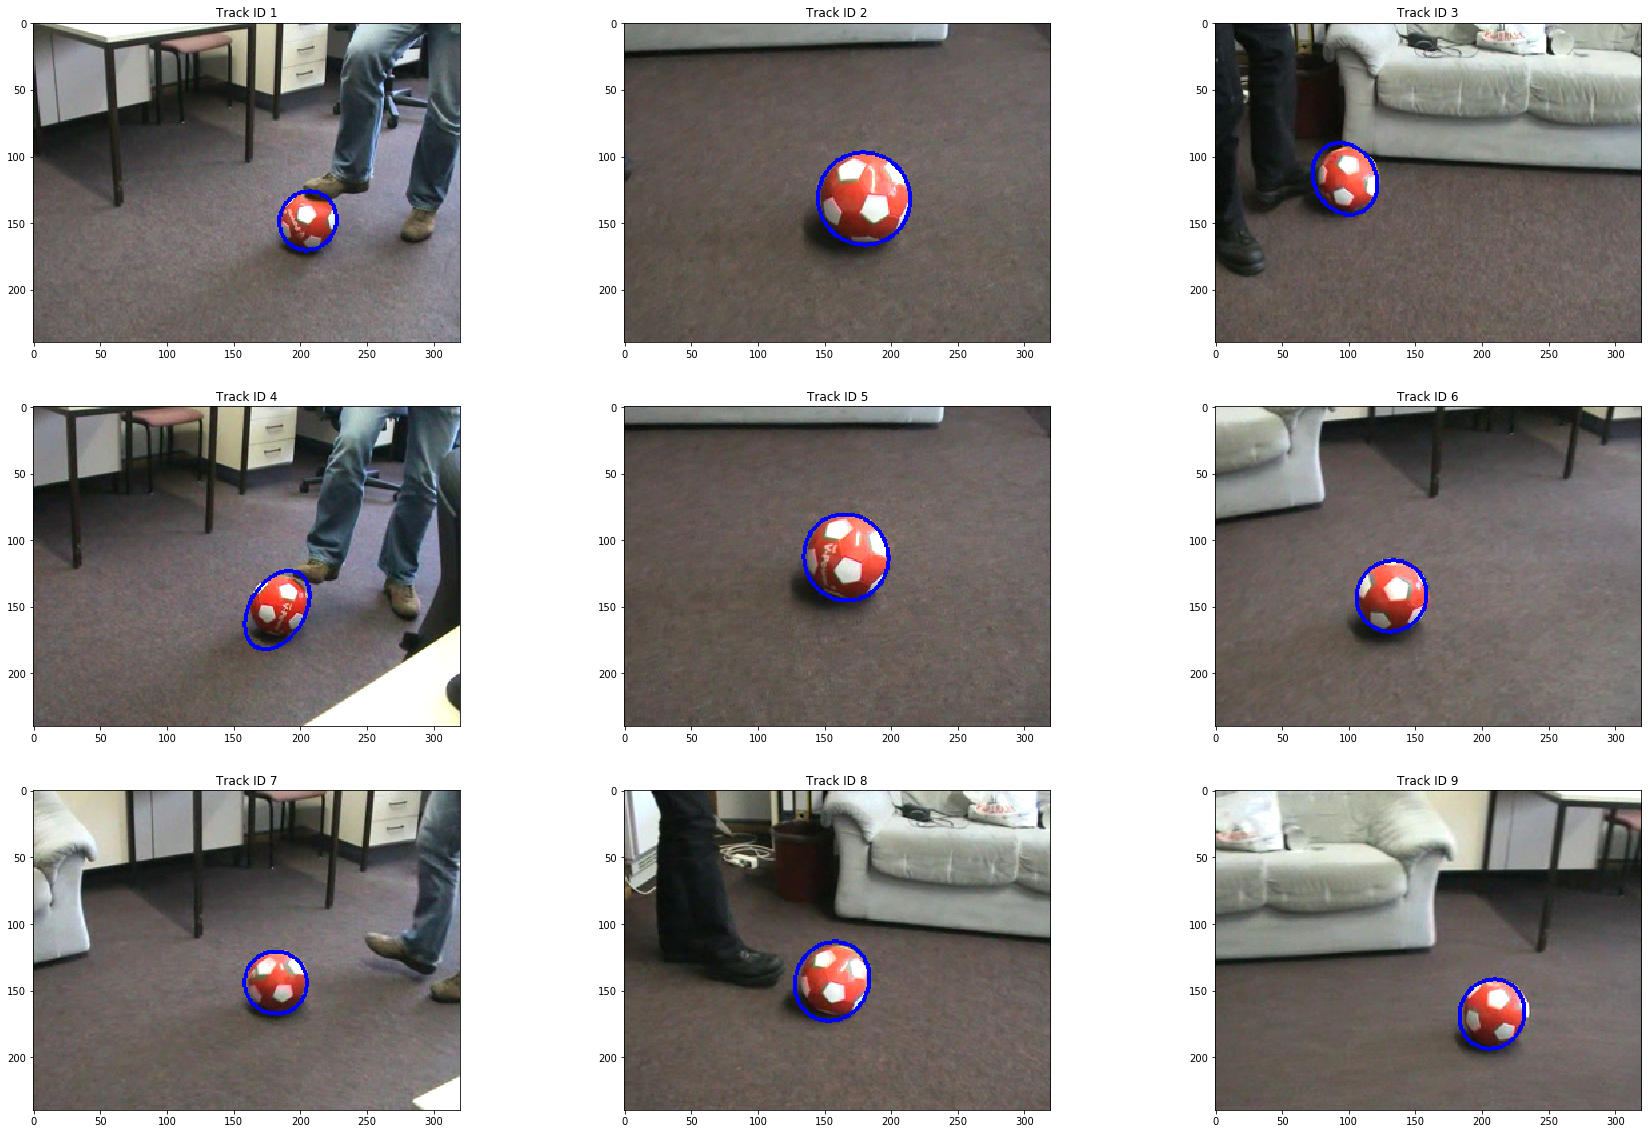

In [5]:
# Object tracking using CAMShift
cap = cv2.VideoCapture("../resources/football.avi")

frame = cap.read()[1]
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, np.array((0, 60, 32), dtype=np.float32), np.array((180, 255, 255), dtype=np.float32))

x, y, w, h = 198, 112, 52, 52
track_window = (x, y, w, h)
hsv_roi = hsv[y : y + h, x : x + w]
mask_roi = mask[y : y + h, x : x + w]

hist = cv2.calcHist([hsv_roi], [0], mask_roi, [16], [0, 180])
cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)

hist = hist.reshape(-1)
term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)

fig = plt.figure()
fig.set_size_inches(30, 20)
batch = 0

while True:
    frame = cap.read()[1]
    if frame is None: break
    
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, np.array((0, 60, 32), dtype=np.float32), np.array((180, 255, 255), dtype=np.float32))
    
    proj = cv2.calcBackProject([hsv], [0], hist, [0, 180], 1)
    proj = proj & mask
    
    track_box, track_window = cv2.CamShift(proj, track_window, term_crit)
    out = cv2.ellipse(frame, track_box, (255, 0, 0), 2)
    batch += 1
    
    if batch % 60 == 0:
        try:
            fig.add_subplot(3, 3, batch // 60)
            plt.title("Track ID %d" % (batch // 60))
            plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
        except: pass

cap.release()
plt.show()